<a href="https://colab.research.google.com/github/VadimGrishin/TuttiFrutti/blob/master/nootbook_for_UrS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVR

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, roc_auc_score as auc

import matplotlib.pyplot as plt

pd.options.display.max_rows=100
pd.options.display.max_columns=250

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [0]:
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

## Загрузка данных

In [0]:
df_train = pd.read_csv('Data.txt', encoding='cp1251', sep=';')

## Преварительная оценка качества данных

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
Месяц выдачи кредита          1723 non-null int64
Сумма кредита                 1723 non-null int64
Срок кредита                  1723 non-null int64
Возраст клиента               1723 non-null int64
Пол клиента                   1723 non-null object
Образование клиента           1723 non-null object
Тип товара                    1723 non-null object
Наличие детей у клиента       1723 non-null object
Регион выдачи кредита         1723 non-null object
Доход клиента                 1723 non-null int64
Семейное положение            1723 non-null object
Оператор связи                1723 non-null object
Является ли клиентом банка    1723 non-null object
Флаг дефолта по кредиту       1723 non-null object
dtypes: int64(5), object(9)
memory usage: 188.5+ KB


In [0]:
# Проведем оцифровку вектора значений (меток классов)
df_train['default_flag'] = (df_train['Флаг дефолта по кредиту'] == 'Дефолт').astype(int)
df_train['loss'] = df_train['default_flag'] * df_train['Сумма кредита']


In [0]:
df_train.describe()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Доход клиента,default_flag,loss
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000
mean,6.708067,29264.654672,11.546721,35.911782,32652.350551,0.113755,3204.585026
std,3.538420,27926.778301,6.548354,13.120203,20913.193158,0.317606,11946.190179
min,1.000000,5000.000000,3.000000,18.000000,1000.000000,0.000000,0.000000
25%,3.000000,13000.000000,6.000000,26.000000,21000.000000,0.000000,0.000000
50%,7.000000,21500.000000,12.000000,32.000000,27000.000000,0.000000,0.000000
75%,10.000000,34000.000000,12.000000,44.000000,38000.000000,0.000000,0.000000
max,12.000000,301000.000000,36.000000,90.000000,401000.000000,1.000000,201000.000000


### Вывод: 
 1) даннные заполнены полностью по всем полям;
 
 2) для числовых полей $\textit{Сумма кредита,	Срок кредита,	Возраст клиента,	Доход клиента}$ можно предположить наличие выбросов в данных, в связи с чем целесообразно провести анализ описательных статистик
 
 3) среднее значение Флага в 11% означает процент дефолтов. Таким, образом датасет несбалансирован, что нужно учитывать в дальнейшем анализе.

## Описательная статистика. Анализ выбросов (нестандартное поведение)

In [0]:
tot_sum = df_train[["Сумма кредита"]].sum()
tot_count = df_train[["Сумма кредита"]].count()
  
def get_fliers(bp, field_name):
  """
  Для ящика с усами bp, построенного по полю field_name,
  определяет агрегированные показатели по выбросам
  
  """
  
  bp_min = bp['caps'][0].get_ydata()[0]
  bp_max = bp['caps'][1].get_ydata()[0]
  median = bp['medians'][0].get_ydata()[0]
  
  filtered_sum = df_train.loc[(df_train[field_name] > bp_max) | 
                              (df_train[field_name] < bp_min), ["Сумма кредита"]].sum()
  filtered_count = df_train.loc[(df_train[field_name] > bp_max) | 
                                (df_train[field_name] < bp_min), ["Сумма кредита"]].count()
  filtered_mean = df_train.loc[(df_train[field_name] > bp_max) | 
                               (df_train[field_name] < bp_min), ["default_flag"]].mean()
  filtered_loss = df_train.loc[(df_train[field_name] > bp_max) | 
                               (df_train[field_name] < bp_min), ["loss"]].sum()
   
  
  print(f'--------------------\nОписание выброса по полю "{field_name}"')
  print(f'Медиана распределения {median}')
  print(f'нижняя граница: {bp_min}, \nверхняя граница: {bp_max}')
  print(f'Количество по выбросу {filtered_count["Сумма кредита"]}, доля {round(filtered_count["Сумма кредита"]/tot_count["Сумма кредита"]*100)} %' )
  print(f'Сумма по выбросу {filtered_sum["Сумма кредита"]}, доля {round(filtered_sum["Сумма кредита"]/tot_sum["Сумма кредита"]*100)} %' )
  
  print(f'Процент дефолтов в группе {filtered_mean["default_flag"] * 100} %')
  print(f'Сумма потерь {filtered_loss["loss"]} р.')
  
  return bp_min, bp_max
  

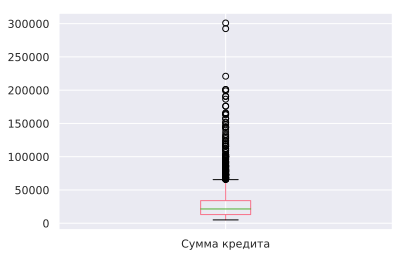

In [0]:
sum_field = "Сумма кредита"
a = df_train[[sum_field]].boxplot(return_type ='dict')


In [0]:
sum_low, sum_high = get_fliers(a, sum_field)

--------------------
Описание выброса по полю "Сумма кредита"
Медиана распределения 21500.0
нижняя граница: 5000.0, 
верхняя граница: 65500.0
Количество по выбросу 130, доля 8.0 %
Сумма по выбросу 13759500, доля 27.0 %
Процент дефолтов в группе 7.6923076923076925 %
Сумма потерь 1043000 р.


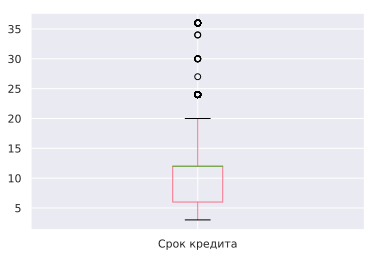

In [0]:
period_field = "Срок кредита"
a = df_train[[period_field]].boxplot(return_type ='dict')

In [0]:
period_low, period_high = get_fliers(a, period_field)

--------------------
Описание выброса по полю "Срок кредита"
Медиана распределения 12.0
нижняя граница: 3.0, 
верхняя граница: 20.0
Количество по выбросу 167, доля 10.0 %
Сумма по выбросу 10406500, доля 21.0 %
Процент дефолтов в группе 10.179640718562874 %
Сумма потерь 1009500 р.


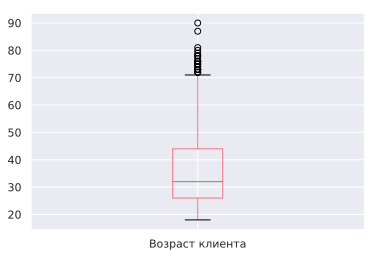

In [0]:
age_field = "Возраст клиента"
a = df_train[[age_field]].boxplot(return_type ='dict')

In [0]:
age_low, age_high = get_fliers(a, age_field)

--------------------
Описание выброса по полю "Возраст клиента"
Медиана распределения 32.0
нижняя граница: 18.0, 
верхняя граница: 71.0
Количество по выбросу 28, доля 2.0 %
Сумма по выбросу 962000, доля 2.0 %
Процент дефолтов в группе 0.0 %
Сумма потерь 0 р.


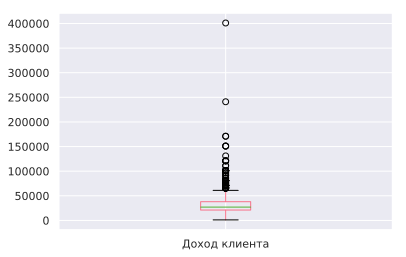

In [0]:
income_field = "Доход клиента"
a = df_train[[income_field]].boxplot(return_type ='dict')

In [0]:
income_low, income_high = get_fliers(a, income_field)

--------------------
Описание выброса по полю "Доход клиента"
Медиана распределения 27000.0
нижняя граница: 1000.0, 
верхняя граница: 61000.0
Количество по выбросу 97, доля 6.0 %
Сумма по выбросу 5818000, доля 12.0 %
Процент дефолтов в группе 3.0927835051546393 %
Сумма потерь 183500 р.


In [0]:
filtered_sum = df_train.loc[(df_train[sum_field] > sum_high) | (df_train[sum_field] < sum_low) | 
                            (df_train[period_field] > period_high) | (df_train[period_field] < period_low) | 
                            (df_train[age_field] > age_high) | (df_train[age_field] < age_low) | 
                            (df_train[income_field] > income_high) | (df_train[income_field] < income_low), ["Сумма кредита"]].sum()


filtered_sum[sum_field], filtered_sum[sum_field]/tot_sum[sum_field]


(20160500, 0.399827459691014)

In [0]:
filtered_count = df_train.loc[(df_train[sum_field] > sum_high) | (df_train[sum_field] < sum_low) | 
                            (df_train[period_field] > period_high) | (df_train[period_field] < period_low) | 
                            (df_train[age_field] > age_high) | (df_train[age_field] < age_low) | 
                            (df_train[income_field] > income_high) | (df_train[income_field] < income_low), ["Сумма кредита"]].count()

filtered_count[sum_field], filtered_count[sum_field]/tot_count[sum_field]

(319, 0.18514219384793965)

In [0]:
filtered_sum = df_train.loc[(df_train[sum_field] > sum_high) | (df_train[sum_field] < sum_low) | 
                            (df_train[period_field] > period_high) | (df_train[period_field] < period_low) | 
                            (df_train[age_field] > age_high) | (df_train[age_field] < age_low) | 
                            (df_train[income_field] > income_high) | (df_train[income_field] < income_low), ["loss"]].sum()


filtered_sum['loss'], df_train['loss'].sum()

(1495500, 5521500)

### Вывод:
Выброс по каждому из числовых полей характеризуется следующими признаками:
- Сумма кредита - более 65500 руб.: 8% кредитов, 27% по общей сумме, 7.7% дефолтов,
- Период кредита - более 20 месяцев: 10% кредитов, 21% по общей сумме, 10.2% дефолтов,
- Возраст клиента - более 71 года: 2% кредитов, 2% по общей сумме, 0% дефолтов
- Доход клиента - более 61000 руб.: 6% кредитов, 12% по общей сумме, 3.1% дефолтов.

В целом в категорию нестандартных попадает 18.5% кредитов на сумму 20 млн. р. Потери по категории 1.5 млн. р. Для сравнения по категории стандартных 30 и 4 млн. р. соответственно.

По параметрам $\textit{Период кредита и Доход клиента}$ очевидна корреляция между параметром и средней величиной кредита: 
- большие суммы кредитов возвращаются в среднем дольше, 
- люди с более высоким доходом не склонны брать кредит на незначительную сумму.

Кредиты на бОльшие суммы гасятся несколько более дисциплинированно (возможно, это связано с более строгой процедурой проверки).

Люди старшего возраста в среднем используют кредиты так же, как остальные, что может говорить об их высокой социальной активности. 0% дефолтов по этой категории свидетельствует также об их социальной ответственности и/или более строгой проверке, требованиях к обеспечению. Впрочем, в силу небольшого объема данных значимость результата не велика.

Существенно меньший по отношению к среднему процент дефолтов у клиентов с доходом более 61000 р. говорит об увеличении социальной ответственности при повышении дохода.

## Анализ сезонности

In [0]:
dict_for_agg = {'Сумма кредита' : ['sum'], 
               'default_flag': ['mean'],
               'Срок кредита':['count']}
monthly_set = df_train.groupby('Месяц выдачи кредита').agg(dict_for_agg).reset_index()
monthly_set.columns = monthly_set.columns.get_level_values(0)

In [0]:
monthly_set = monthly_set.rename(columns={'default_flag': 'Доля дефолтов', 'Сумма кредита':'Сумма выданных', 'Срок кредита':'Количество кредитов'})
monthly_set['Средний кредит'] = monthly_set['Сумма выданных'] / monthly_set['Количество кредитов']

In [0]:
monthly_set

,Месяц выдачи кредита,Сумма выданных,Доля дефолтов,Количество кредитов,Средний кредит
0,1,3641000,0.136691,139,26194.244604
1,2,4165000,0.072464,138,30181.159420
2,3,4494000,0.139241,158,28443.037975
3,4,3820000,0.099237,131,29160.305344
4,5,3022500,0.112069,116,26056.034483
5,6,3771500,0.114754,122,30913.934426
6,7,4163000,0.062069,145,28710.344828
7,8,4079000,0.126761,142,28725.352113
8,9,3573000,0.095588,136,26272.058824
9,10,4658000,0.106250,160,29112.500000


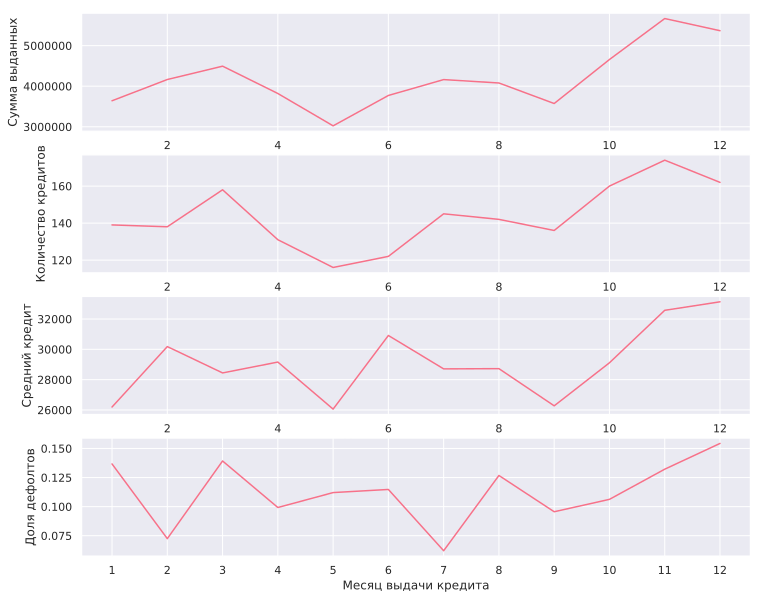

In [0]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10), dpi= 80)
sns.lineplot( x='Месяц выдачи кредита', y='Сумма выданных', data=monthly_set, ax=axes[0])
plt.xticks(list(range(1, 13)))
sns.lineplot( x='Месяц выдачи кредита', y='Количество кредитов', data=monthly_set, ax=axes[1])
plt.xticks(list(range(1, 13)))
sns.lineplot( x='Месяц выдачи кредита', y='Средний кредит', data=monthly_set, ax=axes[2])
plt.xticks(list(range(1, 13)))
sns.lineplot(x='Месяц выдачи кредита', y='Доля дефолтов', data=monthly_set, ax=axes[3])
plt.xticks(list(range(1, 13)))
plt.show()



### Выводы:
Выражены пики активности в марте, июле, ноябре-декабре, что, видимо,  связано с годовым циклом праздников и отпусков.

Корреляция между средним чеком и количеством чеков говорит о том, что расположенность к дорогим покупкам падает / растет быстрее соответствующей расположенности к покупкам вообще.

Интересная закономерность, связанная с притоком надежных заемщиков в феврале и июле (см. график Доля дефолтов). Нужно детально исследовать, с чем это связано.

В тоже время "праздничный ажиотаж" ноября-января привлекает на рынок  большое число недобросовестных заемщиков, что говорит о необходимости более тщательного контроля в этот период. Эту ситуацию также нужно иследовать детально.

## Оцифровка данных

In [0]:
# Оцифровка бинарных полей:

df_train['sex'] = (df_train['Пол клиента'] == 'Мужской').astype(int)
df_train['have_child'] = (df_train['Наличие детей у клиента'] == 'Дети есть').astype(int)
df_train['customer'] = (df_train['Является ли клиентом банка'] == 'Клиент банка').astype(int)

In [0]:
df_train.describe()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Доход клиента,default_flag,loss,sex,have_child,customer
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000
mean,6.708067,29264.654672,11.546721,35.911782,32652.350551,0.113755,3204.585026,0.540337,0.428323,0.604759
std,3.538420,27926.778301,6.548354,13.120203,20913.193158,0.317606,11946.190179,0.498515,0.494979,0.489044
min,1.000000,5000.000000,3.000000,18.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,13000.000000,6.000000,26.000000,21000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,21500.000000,12.000000,32.000000,27000.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,10.000000,34000.000000,12.000000,44.000000,38000.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,12.000000,301000.000000,36.000000,90.000000,401000.000000,1.000000,201000.000000,1.000000,1.000000,1.000000


In [0]:
# оцифровка многозначных полей

dummies = pd.get_dummies(df_train[['Образование клиента', 'Тип товара', 'Регион выдачи кредита', 'Семейное положение', 'Оператор связи']])

In [0]:
df_train[list(dummies.columns)] = dummies

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 58 columns):
Месяц выдачи кредита                                                          1723 non-null int64
Сумма кредита                                                                 1723 non-null int64
Срок кредита                                                                  1723 non-null int64
Возраст клиента                                                               1723 non-null int64
Пол клиента                                                                   1723 non-null object
Образование клиента                                                           1723 non-null object
Тип товара                                                                    1723 non-null object
Наличие детей у клиента                                                       1723 non-null object
Регион выдачи кредита                                                         1723 non-null object
Доход 

## Детальный анализ по категориям товаров и клиентов

In [0]:
educ_month_det = df_train.groupby([ 'Образование клиента']).agg({'default_flag':['sum', 'mean'], 'Сумма кредита':['sum', 'count'], 'loss':['sum'] })
educ_month_det

default_flag            \
                                                            sum      mean   
Образование клиента                                                         
Высшее                                                       35  0.059829   
Неоконченное высшее                                           5  0.058140   
Неоконченное среднее                                          0  0.000000   
Несколько высших или более высокая ступень обра...            0  0.000000   
Среднее                                                      40  0.192308   
Среднее специальное                                         116  0.138756   

                                                   Сумма кредита        \
                                                             sum count   
Образование клиента                                                      
Высшее                                                  21874000   585   
Неоконченное высшее                                      2283000    86   
Неоконченное среднее                                      205000     5   
Несколько высших или более высокая ступень обра...         41000     3   
Среднее                                                  5152000   208   
Среднее специальное                                     20868000   836   

                                                       loss  
                                                        sum  
Образование клиента                                          
Высшее                                              1345500  
Неоконченное высшее                                  183000  
Неоконченное среднее                                      0  
Несколько высших или более высокая ступень обра...        0  
Среднее                                              877500  
Среднее специальное                                 3115500

In [0]:
good_month_det = df_train.groupby([ 'Тип товара']).agg({'default_flag':['sum', 'mean'], 'Сумма кредита':['sum', 'count'], 'loss':['sum'] })
good_month_det

default_flag            \
                                                            sum      mean   
Тип товара                                                                  
Автомобильные товары                                          3  0.142857   
Аудио, Видео, Фото                                            0  0.000000   
Бытовая техника                                              36  0.076433   
Детские товары (игрушки, детская одежда, детска...            0  0.000000   
Компьютеры, комплектующие                                     8  0.044944   
Косметика и косметические услуги                              5  0.090909   
Мебель                                                        8  0.048780   
Медицинские услуги                                            1  0.037037   
Мобильные телефоны                                          113  0.226908   
Мототехника (лодки, мото)                                     1  0.090909   
Музыка                                                        0  0.000000   
Обучение                                                      0  0.000000   
Одежда, изделия из меха и кожи                                4  0.045455   
Окна, двери                                                   2  0.042553   
Рыболовные и охотничьи принадлежности                         0  0.000000   
Садовая техника                                               0  0.000000   
Спортивные товары                                             0  0.000000   
Строительные и ремонтные услуги                               1  0.333333   
Строительные материалы и инструменты                          4  0.133333   
Туризм и отдых                                                2  0.054054   
Фитнес                                                        0  0.000000   
Ювелирные украшения                                           8  0.222222   

                                                   Сумма кредита        \
                                                             sum count   
Тип товара                                                               
Автомобильные товары                                      649000    21   
Аудио, Видео, Фото                                        237000     9   
Бытовая техника                                         12068500   471   
Детские товары (игрушки, детская одежда, детска...        189500     2   
Компьютеры, комплектующие                                4024000   178   
Косметика и косметические услуги                         3322000    55   
Мебель                                                   6582000   164   
Медицинские услуги                                       1253000    27   
Мобильные телефоны                                       9158500   498   
Мототехника (лодки, мото)                                 843000    11   
Музыка                                                      8000     1   
Обучение                                                  502000    10   
Одежда, изделия из меха и кожи                           4262500    88   
Окна, двери                                              1888500    47   
Рыболовные и охотничьи принадлежности                      37000     1   
Садовая техника                                            78000     3   
Спортивные товары                                         112500     6   
Строительные и ремонтные услуги                           191500     3   
Строительные материалы и инструменты                     1413500    30   
Туризм и отдых                                           2304500    37   
Фитнес                                                    640000    25   
Ювелирные украшения                                       658500    36   

                                                       loss  
                                                        sum  
Тип товара                                                   
Автомобильные товары                                  95000  
Аудио, Видео, Фото        

In [0]:
reg_month_det = df_train.groupby([ 'Регион выдачи кредита']).agg({'default_flag':['sum', 'mean'], 'Сумма кредита':['sum', 'count'], 'loss':['sum'] })
reg_month_det

default_flag           Сумма кредита           loss
                                sum      mean           sum count      sum
Регион выдачи кредита                                                     
Другие регионы                  171  0.120934      38510000  1414  4631500
Москва или МО                    21  0.087500       9673000   240   745500
Санкт-Петербург или ЛО            4  0.057971       2240000    69   144500

In [0]:
def draw_credcnt_monthly(field):
  df = df_train.groupby([ field, 'Месяц выдачи кредита']).agg({'default_flag':['sum'], 'Сумма кредита':['sum', 'count'], 'loss':['sum'] })
  df['proc'] = df['loss']['sum'] / df['Сумма кредита']['sum']
  df['Всего кредитов'] = df['Сумма кредита']['count']
  df = df.reset_index()
  fig, axe = plt.subplots(1, 1,  figsize= (16,10), dpi= 80)
  ax = sns.lineplot(x='Месяц выдачи кредита', y="Всего кредитов", hue=field, data=df, ax=axe)
  plt.xticks(list(range(1, 13)))
  plt.show

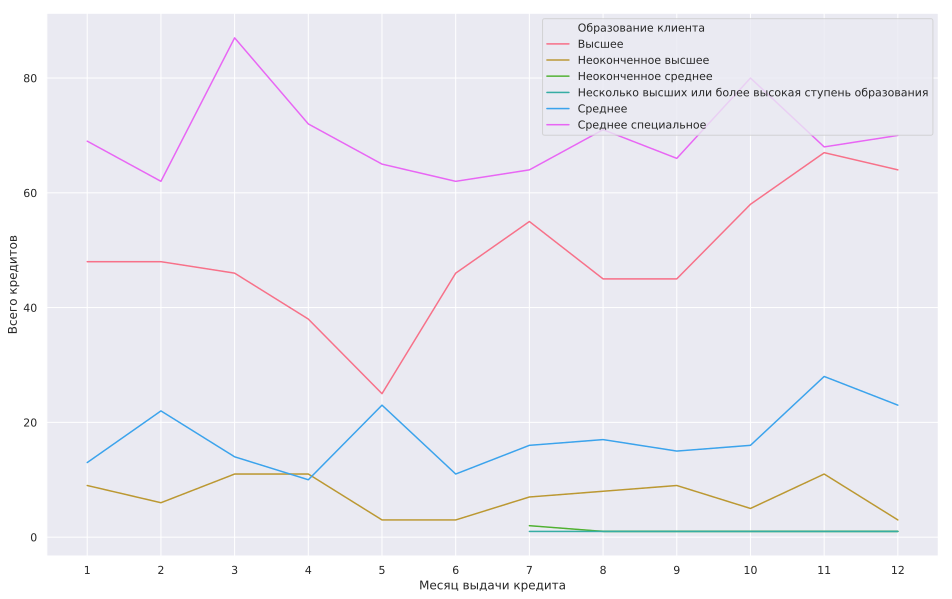

In [0]:
draw_credcnt_monthly('Образование клиента')

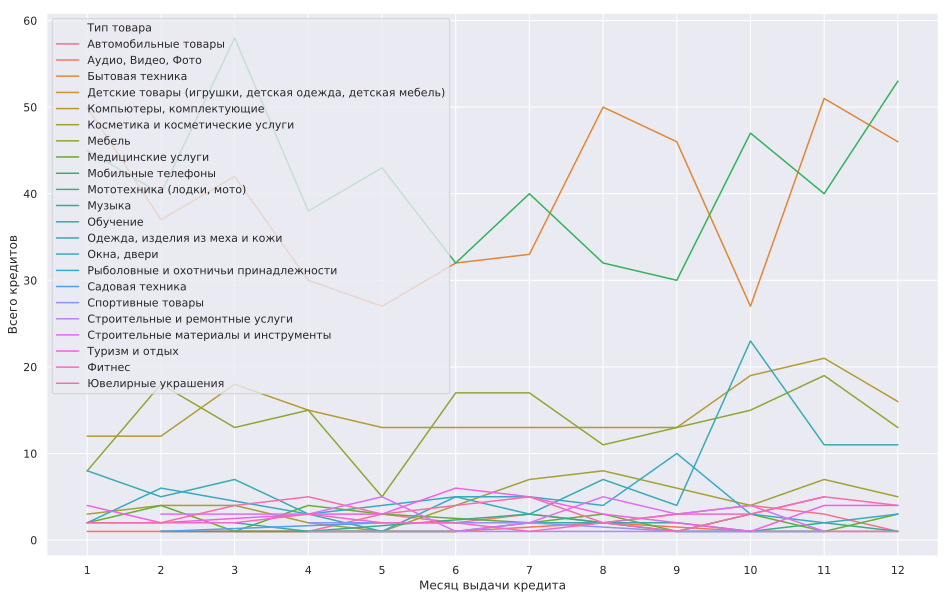

In [0]:
draw_credcnt_monthly('Тип товара')

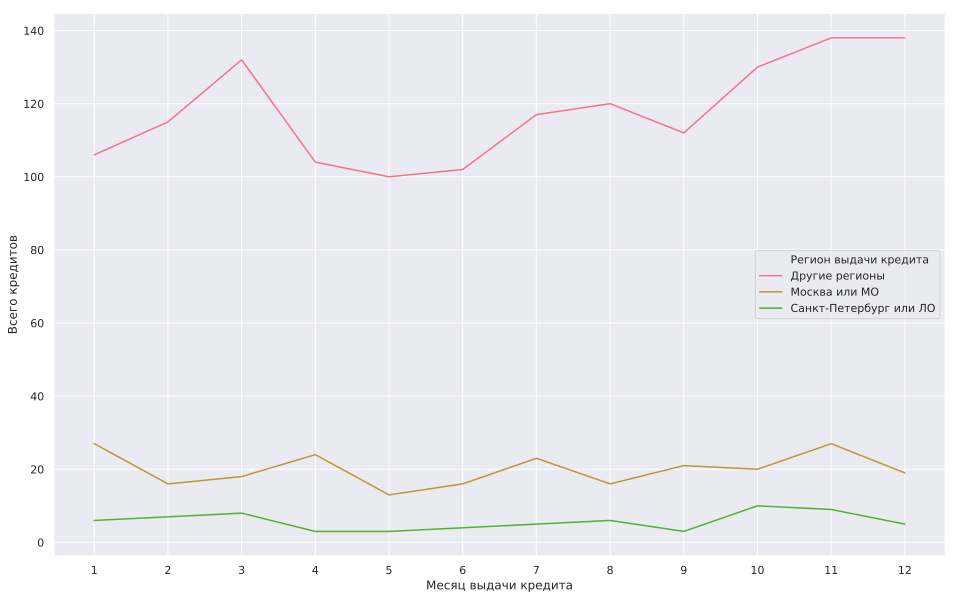

In [0]:
draw_credcnt_monthly('Регион выдачи кредита')

## Вывод:
К наиболее проблемным категориям заемщиков следует отнести клиентов со средним и средним специальным образованием.

Наиболее проблемные товары:

- Мобильные телефоны	общая сумма кредитов - 9 158 500 р., потери 26%
- Строительные и ремонтные услуги	-	191 500 р., потери 42%
- Строительные материалы и инструменты	-	1 413 500,	потери 19%
- Ювелирные украшения	-	658 500р.,	потери 31%

Москва и Спб смотрятся лучше с точки зрения риска потерь по кредитам, чем остальные регионы, что можно объяснить более высоким уровнем доходов населения.

Детальный анализ  сезонных колебаний в феврале, июле не показывает корреляции с колебаниями спроса от отдельных категорий товаров и клиентов. Сезонный "прилив честности" в феврале и июле возможно связан с организационными мероприятиями по повышению требовательности самого банка, проводимымми по окончании полугодового и годового периода.

Интересно отметить рост числа покупок таких проблемных товаров как мобильные телефоны в период предновогоднего ажиотажа.



## Моделирование

In [0]:
train, valid = train_test_split(df_train, test_size=0.3, random_state=42, stratify=df_train['default_flag'])

In [0]:
good_risk = train.groupby('Тип товара')['default_flag'].mean().reset_index().rename(columns={'default_flag': 'good_risk'})
good_risk


,Тип товара,good_risk
0,Автомобильные товары,0.066667
1,"Аудио, Видео, Фото",0.000000
2,Бытовая техника,0.082019
3,"Детские товары (игрушки, детская одежда, детск...",0.000000
4,"Компьютеры, комплектующие",0.046875
5,Косметика и косметические услуги,0.125000
6,Мебель,0.031746
7,Медицинские услуги,0.000000
8,Мобильные телефоны,0.227920
9,"Мототехника (лодки, мото)",0.000000


In [0]:
educ_risk = train.groupby('Образование клиента')['default_flag'].mean().reset_index().rename(columns={'default_flag': 'educ_risk'})
educ_risk

,Образование клиента,educ_risk
0,Высшее,0.064039
1,Неоконченное высшее,0.044776
2,Неоконченное среднее,0.000000
3,Несколько высших или более высокая ступень обр...,0.000000
4,Среднее,0.213793
5,Среднее специальное,0.132302


In [0]:
train = train.merge(good_risk, on='Тип товара', how='left')


In [0]:
train = train.merge(educ_risk, on='Образование клиента', how='left')
train.info()

In [0]:
valid = valid.merge(good_risk, on='Тип товара', how='left')
valid = valid.merge(educ_risk, on='Образование клиента', how='left')
valid = valid.fillna(0)
valid.info()

In [0]:
feats = train.columns[[0,1,2,3,9]+list(range(14, len(train.columns)))]
feats = list(feats)
feats.remove('loss')
feats.remove('default_flag')
feats

In [0]:
estimators = 5
def eval_RF(trn, tst, feats, n_est=estimators, mx_d=3, max_features=50, rnd_st=42):
    # Оценка метрик модели 
    model = RF(n_estimators=n_est, max_depth=mx_d, random_state=rnd_st, criterion='entropy')
    model.fit(trn[feats], trn['default_flag'])
    
    pred_trn = model.predict_proba(trn.loc[:, feats]).T[1]
    auc_trn = auc(trn['default_flag'], pred_trn)
    
    pred_tst = model.predict_proba(tst.loc[:, feats]).T[1]
    auc_tst = auc(tst['default_flag'], pred_tst)
    
    return auc_trn, auc_tst, model   

In [0]:
auc_trn, auc_tst, rf = eval_RF(train, valid, feats)
auc_trn, auc_tst

(0.7747775736925839, 0.7234290578047516)

In [0]:
# Выгрузка решающих дереьвьев для составления процедурных эвристик
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
for i in range(estimators):
    tree = rf.estimators_[i]
    # Export the image to a dot file
    export_graphviz(tree, out_file = f'tree{str(i)}.dot', feature_names = feats, rounded = True, precision = 1)
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file(f'tree{str(i)}.dot')
    # Write graph to a png file
    graph.write_png(f'tree{str(i)}.png')